# Preprocessing

In [1]:
import numpy as np
import pandas as pd
import scanpy as sc

In [20]:
sc.settings.verbosity = 3             # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.logging.print_header()
sc.settings.set_figure_params(dpi=80, facecolor='white')

scanpy==1.8.2 anndata==0.7.8 umap==0.5.2 numpy==1.21.2 scipy==1.7.1 pandas==1.2.5 scikit-learn==1.0.1 statsmodels==0.12.1 python-igraph==0.9.8 louvain==0.7.0 pynndescent==0.5.5


In [21]:
results_file = '/home/chiara/Documents/Università/Git/scan/write/pbmc3k.h5ad'  # the file that will store the analysis results

In [22]:
adata = sc.read_10x_mtx(
    '/home/chiara/Documents/Università/IIIANNO/Tirocinio/data/filtered_gene_bc_matrices/hg19/',  # the directory with the `.mtx` file
    var_names='gene_symbols',                # use gene symbols for the variable names (variables-axis index)
    cache=True)                              # write a cache file for faster subsequent reading

... reading from cache file cache/home-chiara-Documents-Università-IIIANNO-Tirocinio-data-filtered_gene_bc_matrices-hg19-matrix.h5ad


In [23]:
#adata.var_names_make_unique()  # this is unnecessary if using `var_names='gene_ids'` in `sc.read_10x_mtx`

In [24]:
adata.shape

(2700, 32738)

# Preprocessing

Mostriamo i geni con il numero maggiore di counts per ogni single cell

normalizing counts per cell
    finished (0:00:00)


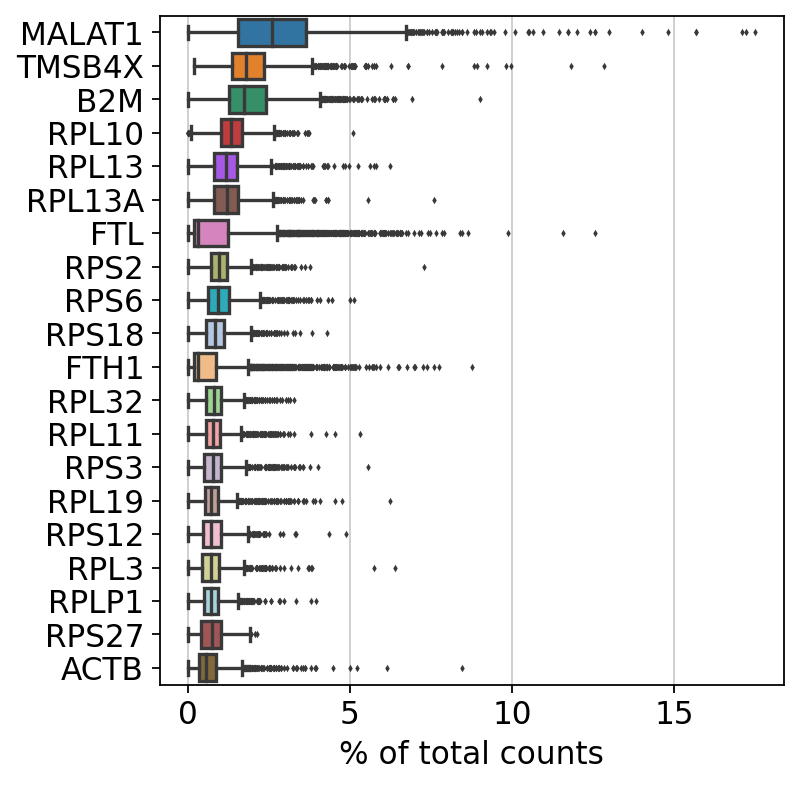

In [25]:
sc.pl.highest_expr_genes(adata, n_top=20) 

## Basic filtering

In [26]:
sc.pp.filter_cells(adata, min_genes=200)
sc.pp.filter_genes(adata, min_cells=3)

filtered out 19024 genes that are detected in less than 3 cells


## Computazione per identificare i gruppi di geni mitocondriali

In [27]:
adata.var['mt']= adata.var_names.str.startswith('MT-') #annotazione dei gruppi di geni mitocondriali
sc.pp.calculate_qc_metrics(adata, qc_vars=['mt'], percent_top=None, log1p=False, inplace=True)

### Violin plot di alcune delle misure di qualità

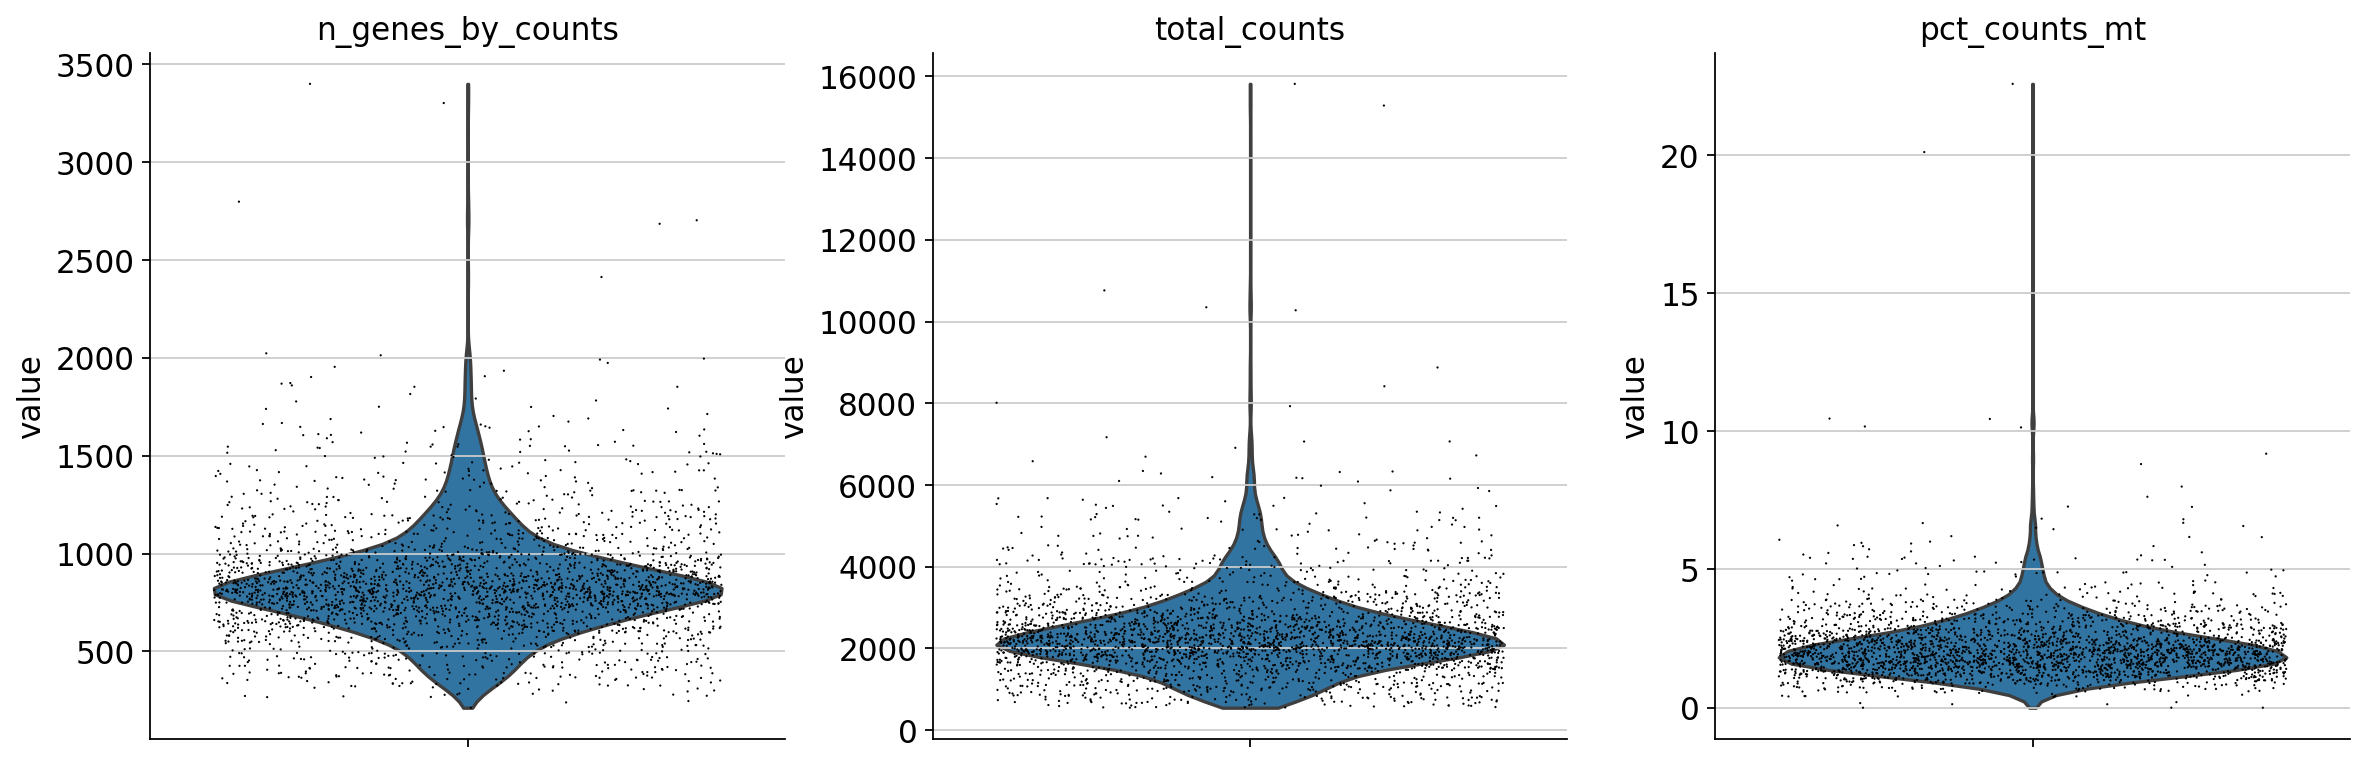

In [28]:
sc.pl.violin(adata, ['n_genes_by_counts','total_counts', 'pct_counts_mt'], jitter=0.4, multi_panel=True) 

## Rimuovo i geni che hanno troppi geni mitocondriali espressi o troppe counts totali

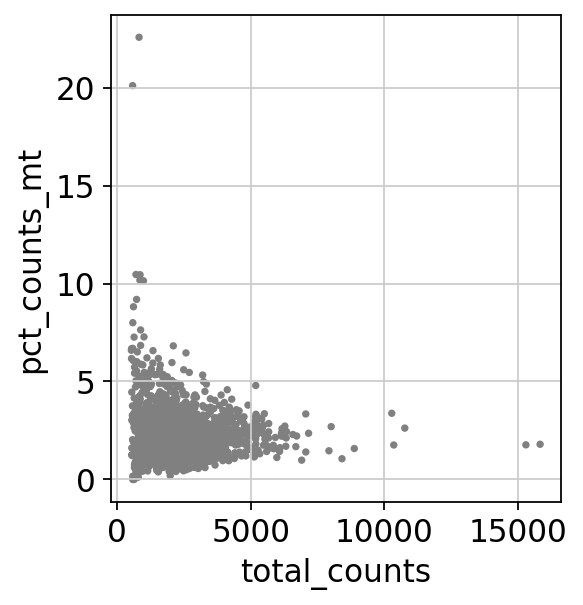

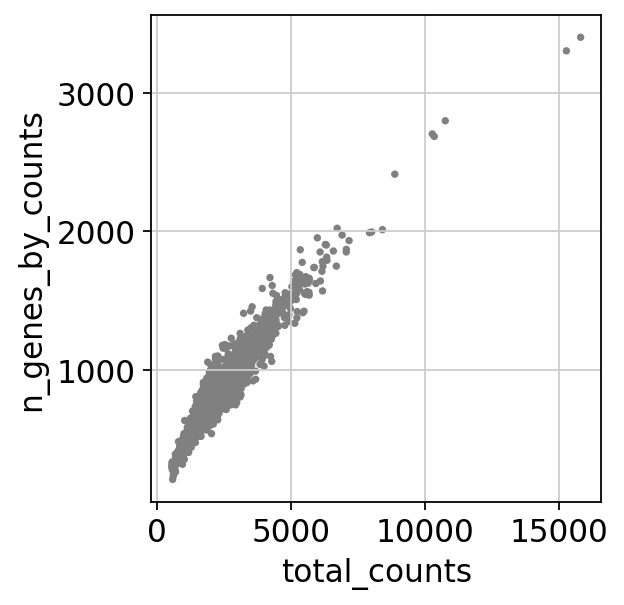

In [29]:
sc.pl.scatter(adata, x='total_counts', y='pct_counts_mt')
sc.pl.scatter(adata, x='total_counts', y='n_genes_by_counts')

## Applico effettivamente il filtering ai dati
- modificando adata

In [30]:
adata = adata[adata.obs.n_genes_by_counts < 2500, :]
adata = adata[adata.obs.pct_counts_mt < 5, :]
adata

View of AnnData object with n_obs × n_vars = 2638 × 13714
    obs: 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt'
    var: 'gene_ids', 'n_cells', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts'

adata adesso ha righe e colonne diverse, mentre obs e var sono ovviamente diversi da quelli visti all'inizio
## Normalizziamo i dati in modo che ci siano 10.000 reads per cellula, così che le counts diventino comparabili tra tutte le cellule

In [31]:
sc.pp.normalize_total(adata, target_sum=1e4)

normalizing counts per cell
    finished (0:00:00)


/home/chiara/anaconda3/envs/scan/lib/python3.8/site-packages/scanpy/preprocessing/_normalization.py:155: UserWarning: Revieved a view of an AnnData. Making a copy.
  view_to_actual(adata)


In [32]:
sc.pp.log1p(adata) #logaritmizzare i dati

### Identifichiamo i geni altamente variabili

In [33]:
sc.pp.highly_variable_genes(adata, min_mean=0.0125, max_mean=3, min_disp=0.5)

extracting highly variable genes
    finished (0:00:00)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)


## Trovare i geni altamente variabili per vedere di che tipo sono

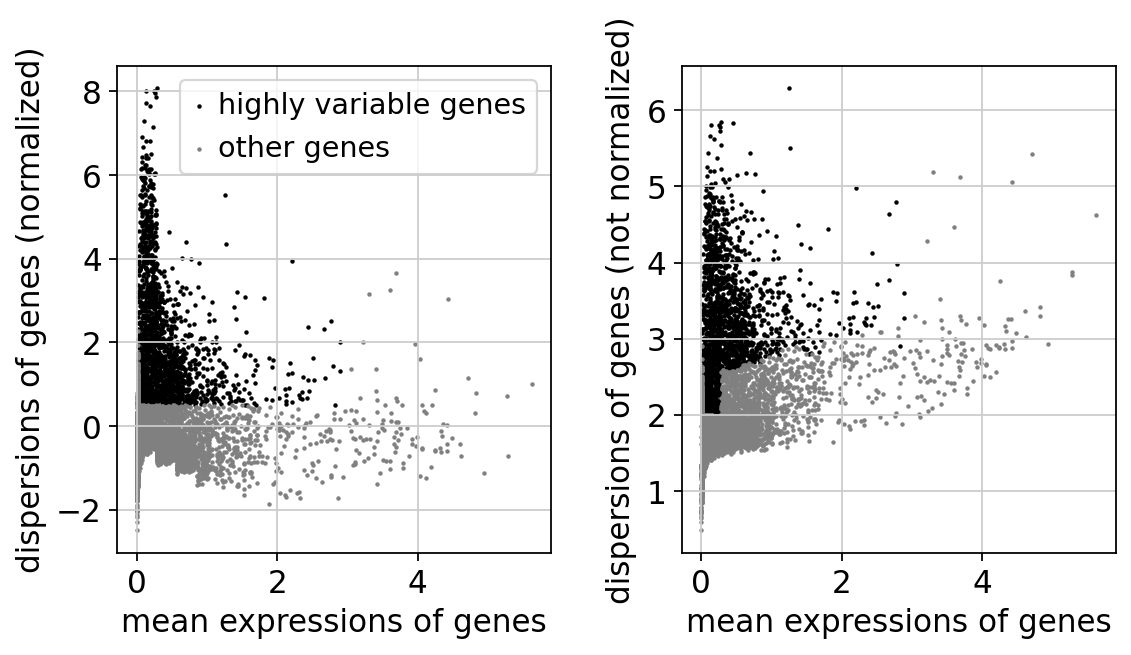

In [36]:
sc.pl.highly_variable_genes(adata)

## Ritorno ai raw data

### Faccio effettivamente il filtering, poi la regression e lo scaling

In [37]:
adata.raw = adata   #????

In [38]:
adata = adata[:, adata.var.highly_variable]

In [39]:
sc.pp.regress_out(adata,  ['total_counts','pct_counts_mt'])

regressing out ['total_counts', 'pct_counts_mt']
    sparse input is densified and may lead to high memory use
    finished (0:00:12)


In [40]:
sc.pp.scale(adata, max_value=10)

# Principal Component Analysis

In [41]:
sc.tl.pca(adata, svd_solver='arpack')

computing PCA
    on highly variable genes
    with n_comps=50
    finished (0:00:01)


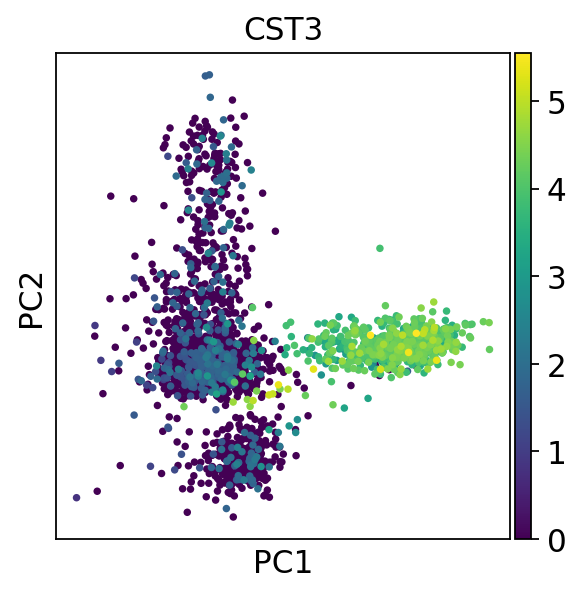

In [42]:
sc.pl.pca(adata, color='CST3')

Verifichiamo il contributo dei sincoli PC sulla varianza totale dei dati

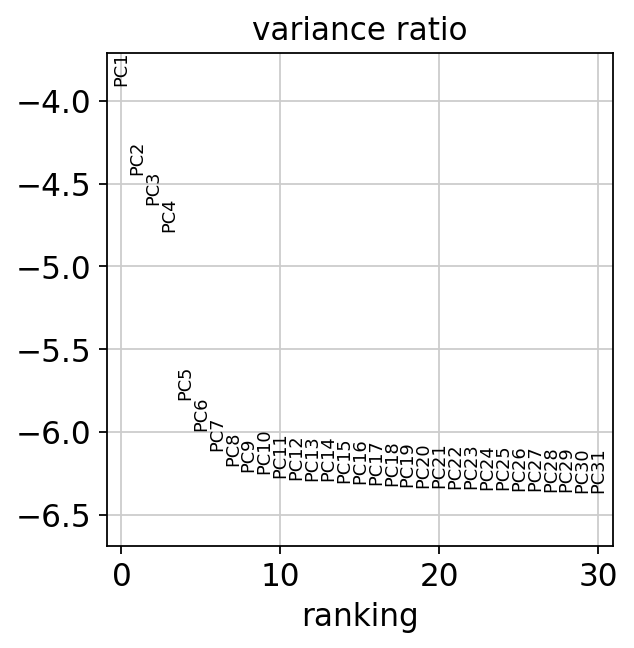

In [43]:
sc.pl.pca_variance_ratio(adata, log=True)

In [44]:
adata.write(results_file)

In [45]:
adata

AnnData object with n_obs × n_vars = 2638 × 1838
    obs: 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt'
    var: 'gene_ids', 'n_cells', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std'
    uns: 'log1p', 'hvg', 'pca'
    obsm: 'X_pca'
    varm: 'PCs'

# Computazione del neighborood graph

In [46]:
sc.pp.neighbors(adata, n_neighbors=10, n_pcs=40)

computing neighbors
    using 'X_pca' with n_pcs = 40
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:05)


# Embedding del neighborhood graph

In [47]:
#sc.tl.louvain(adata)
#sc.tl.paga(adata)
#sc.pl.paga(adata, plot=False)
#sc.tl.umap(adata, init_pos='paga')

In [48]:
sc.tl.umap(adata)

computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:09)


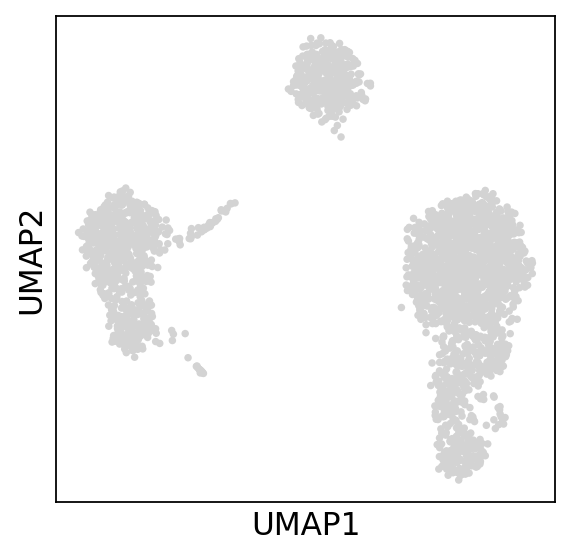

In [49]:
sc.pl.umap(adata)#, color=['louvain'])

Non raw data

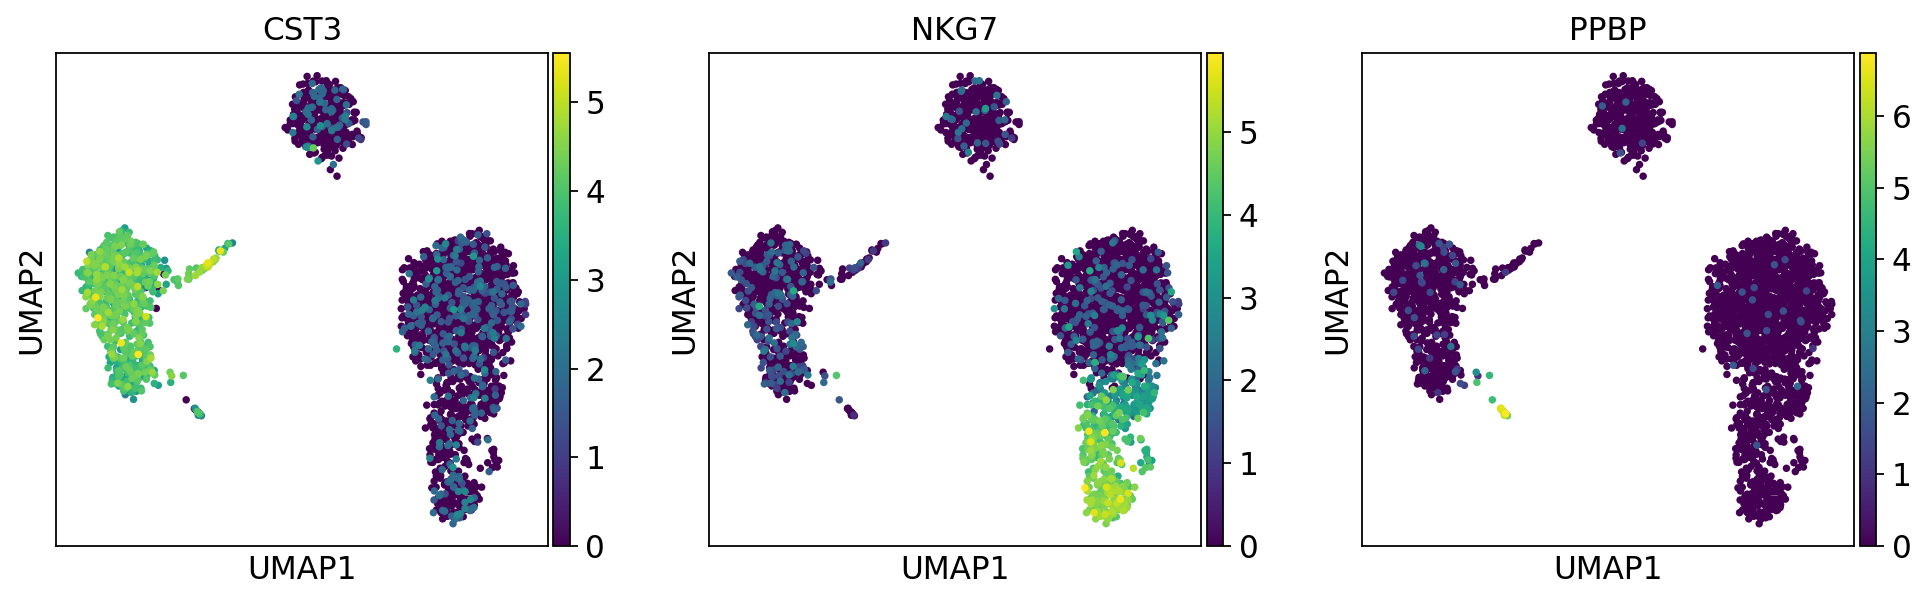

In [50]:
sc.pl.umap(adata, color=['CST3', 'NKG7', 'PPBP'], use_raw=True)

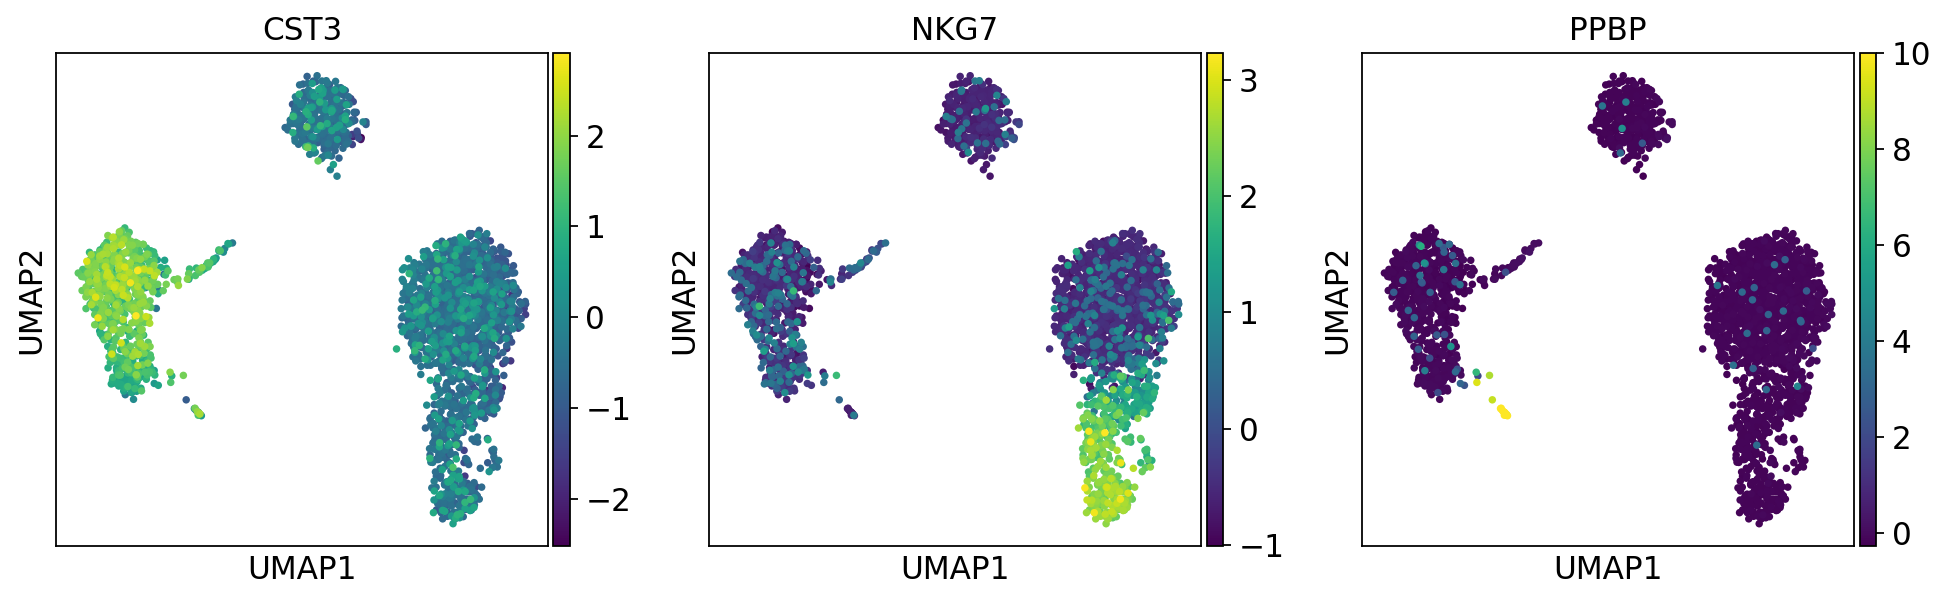

In [51]:
sc.pl.umap(adata, color=['CST3', 'NKG7', 'PPBP'], use_raw=False)

# Clustering del neighborhood graph

In [52]:
sc.tl.leiden(adata)

running Leiden clustering
    finished: found 9 clusters and added
    'leiden', the cluster labels (adata.obs, categorical) (0:00:00)


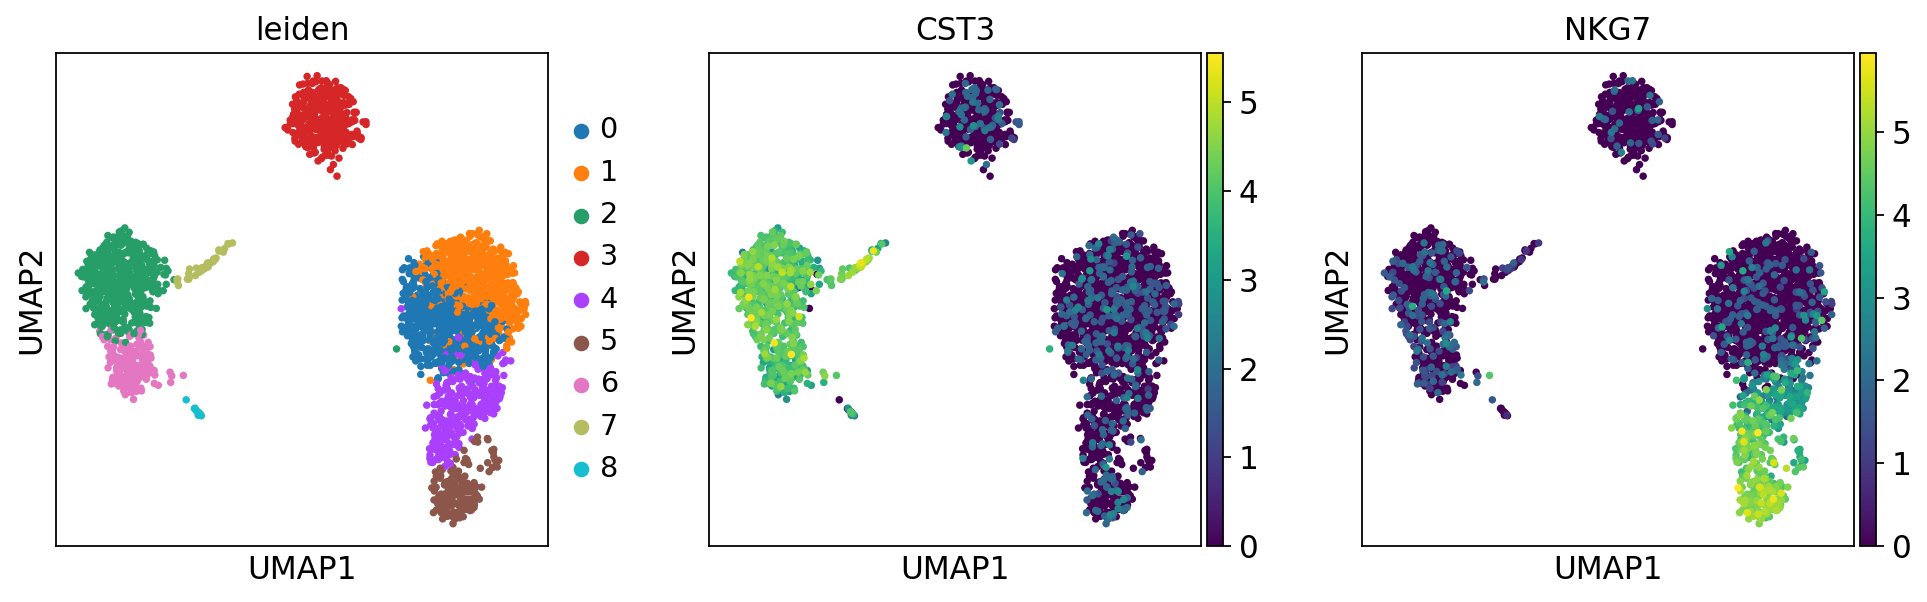

In [53]:
sc.pl.umap(adata, color=['leiden', 'CST3', 'NKG7'])

In [54]:
sc.tl.tsne(adata)

computing tSNE
    using 'X_pca' with n_pcs = 50
    using sklearn.manifold.TSNE


/home/chiara/anaconda3/envs/scan/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(


    finished: added
    'X_tsne', tSNE coordinates (adata.obsm) (0:00:25)


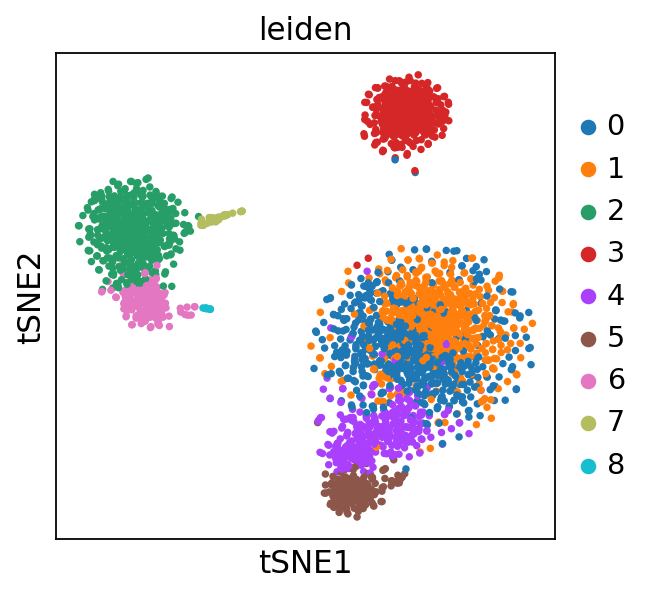

In [55]:
sc.pl.tsne(adata, color=['leiden'])

In [56]:
adata.write(results_file)

# Trovare i geni marker

ranking genes
    finished: added to `.uns['rank_genes_groups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:00)


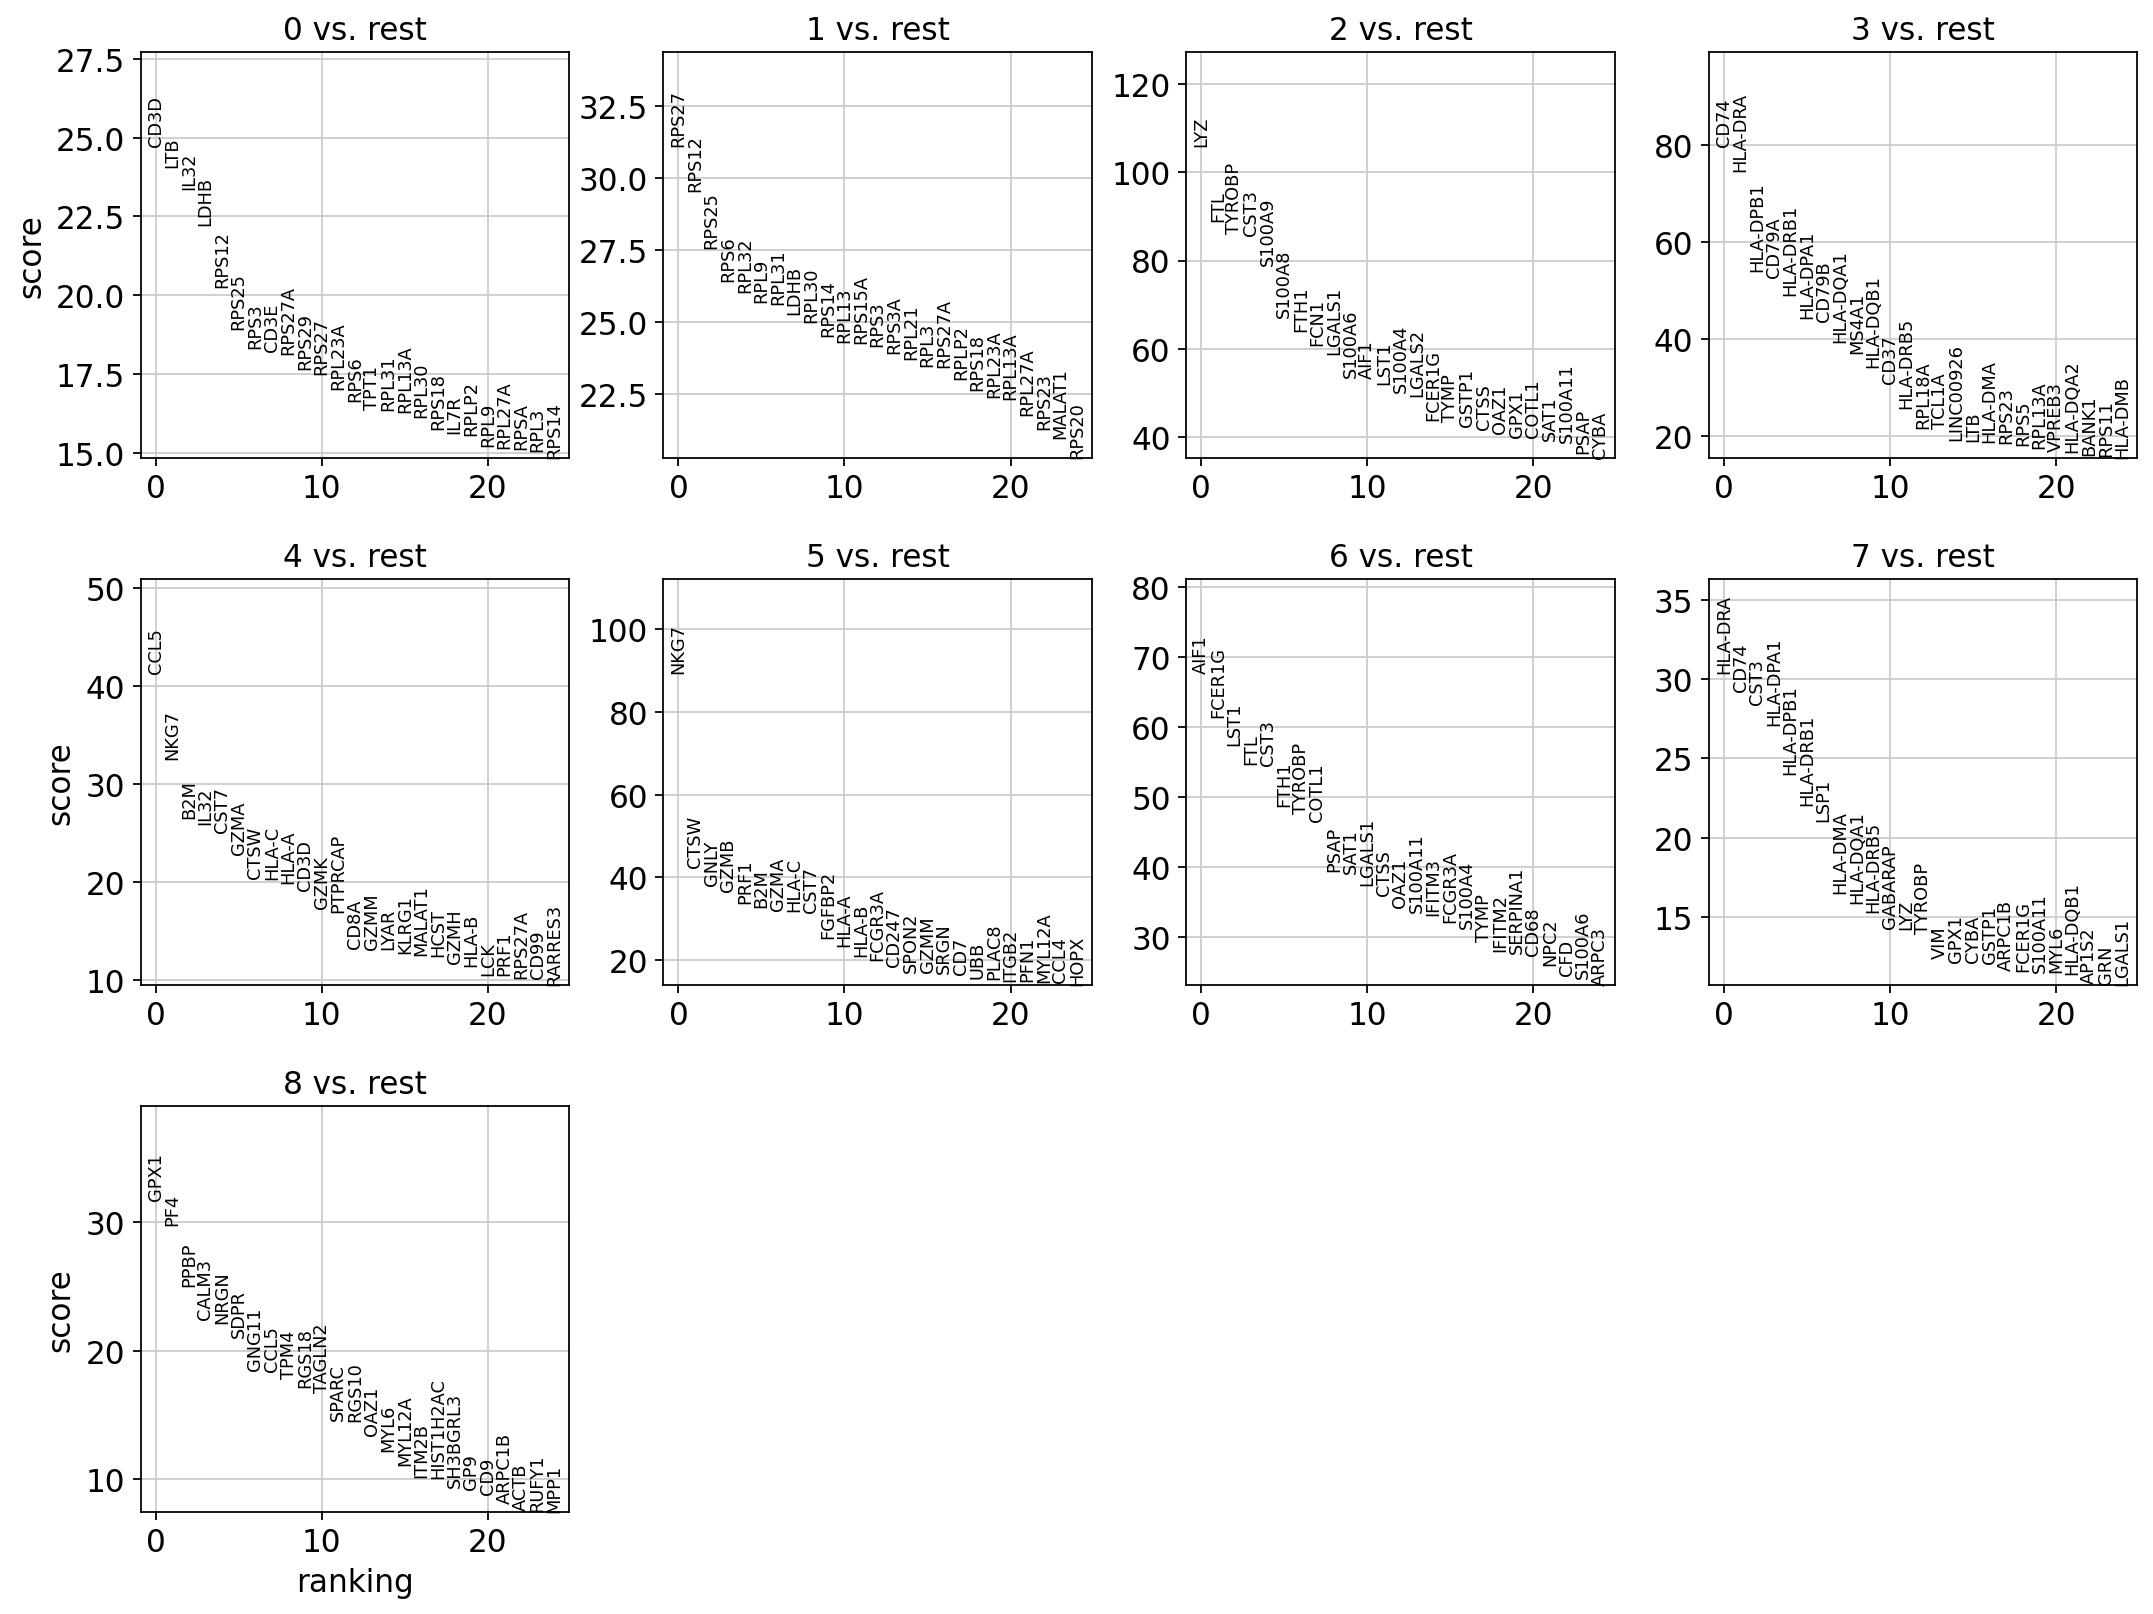

In [57]:
sc.tl.rank_genes_groups(adata, 'leiden', method='t-test')
sc.pl.rank_genes_groups(adata, n_genes=25, sharey=False)

In [58]:
sc.settings.verbosity=2

ranking genes
    finished (0:00:06)


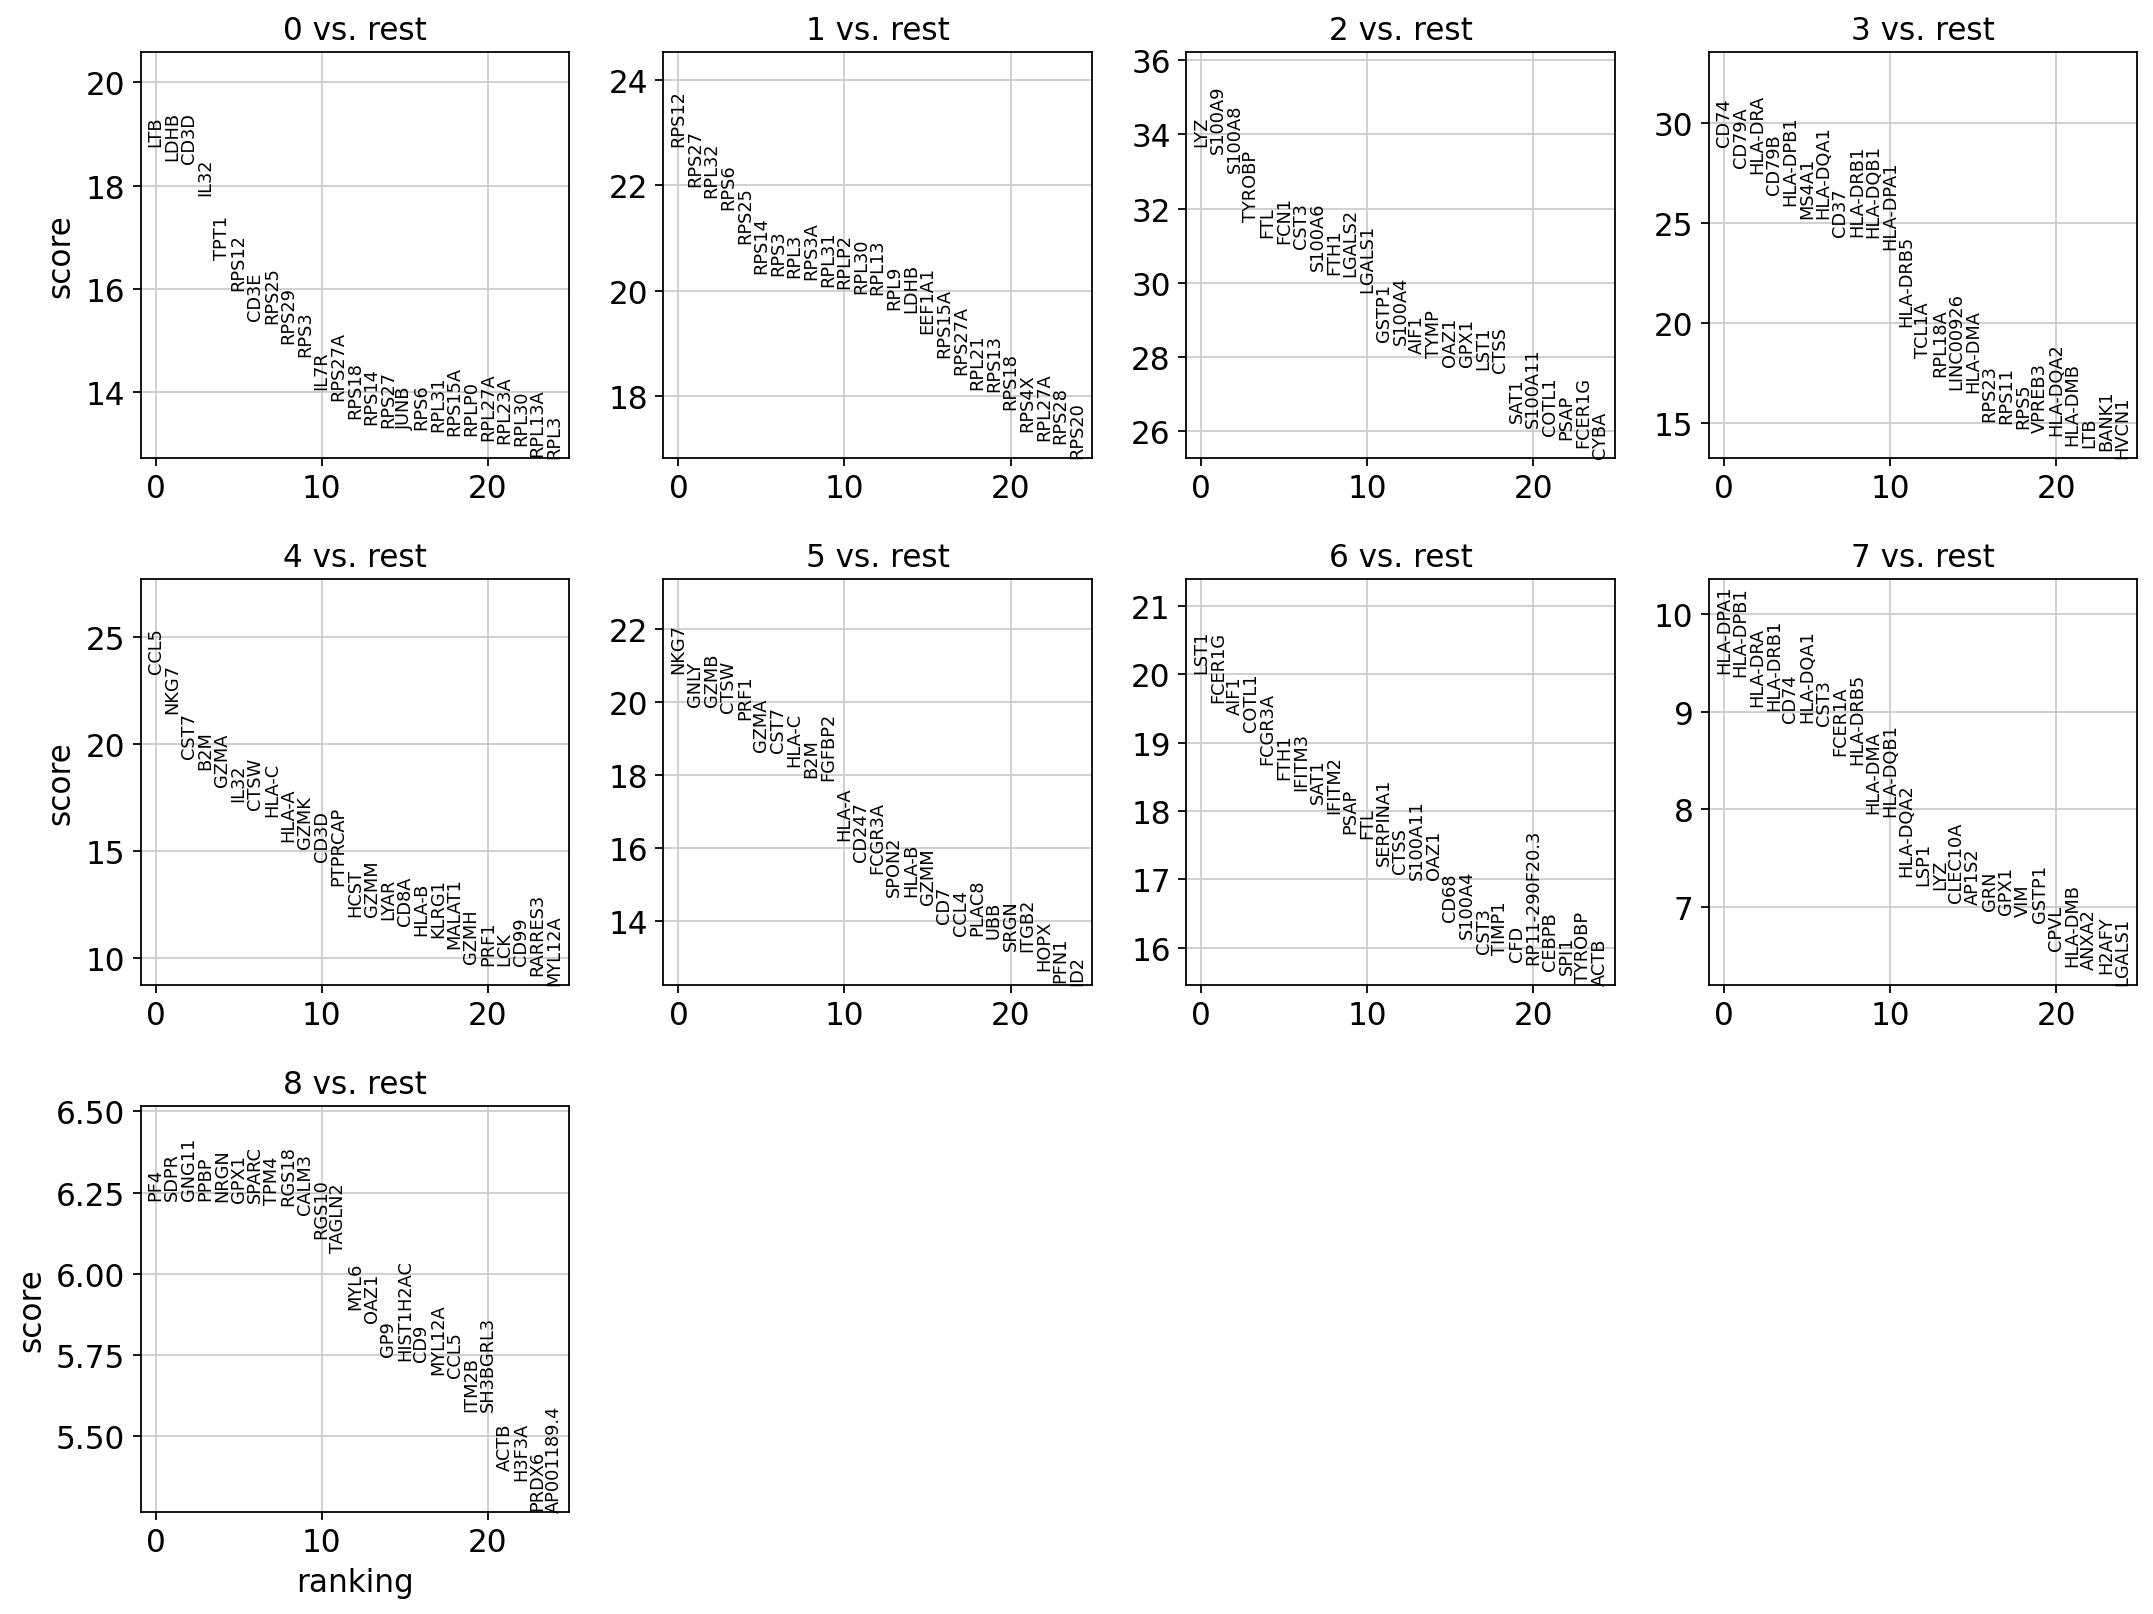

In [59]:
sc.tl.rank_genes_groups(adata, 'leiden', method='wilcoxon')
sc.pl.rank_genes_groups(adata, n_genes=25, sharey=False)

## Logistic Regression
### - aggiunta del solver='liblinear' a causa di un errore
### - commentato per problemi con il read e write

ranking genes
    finished (0:00:07)


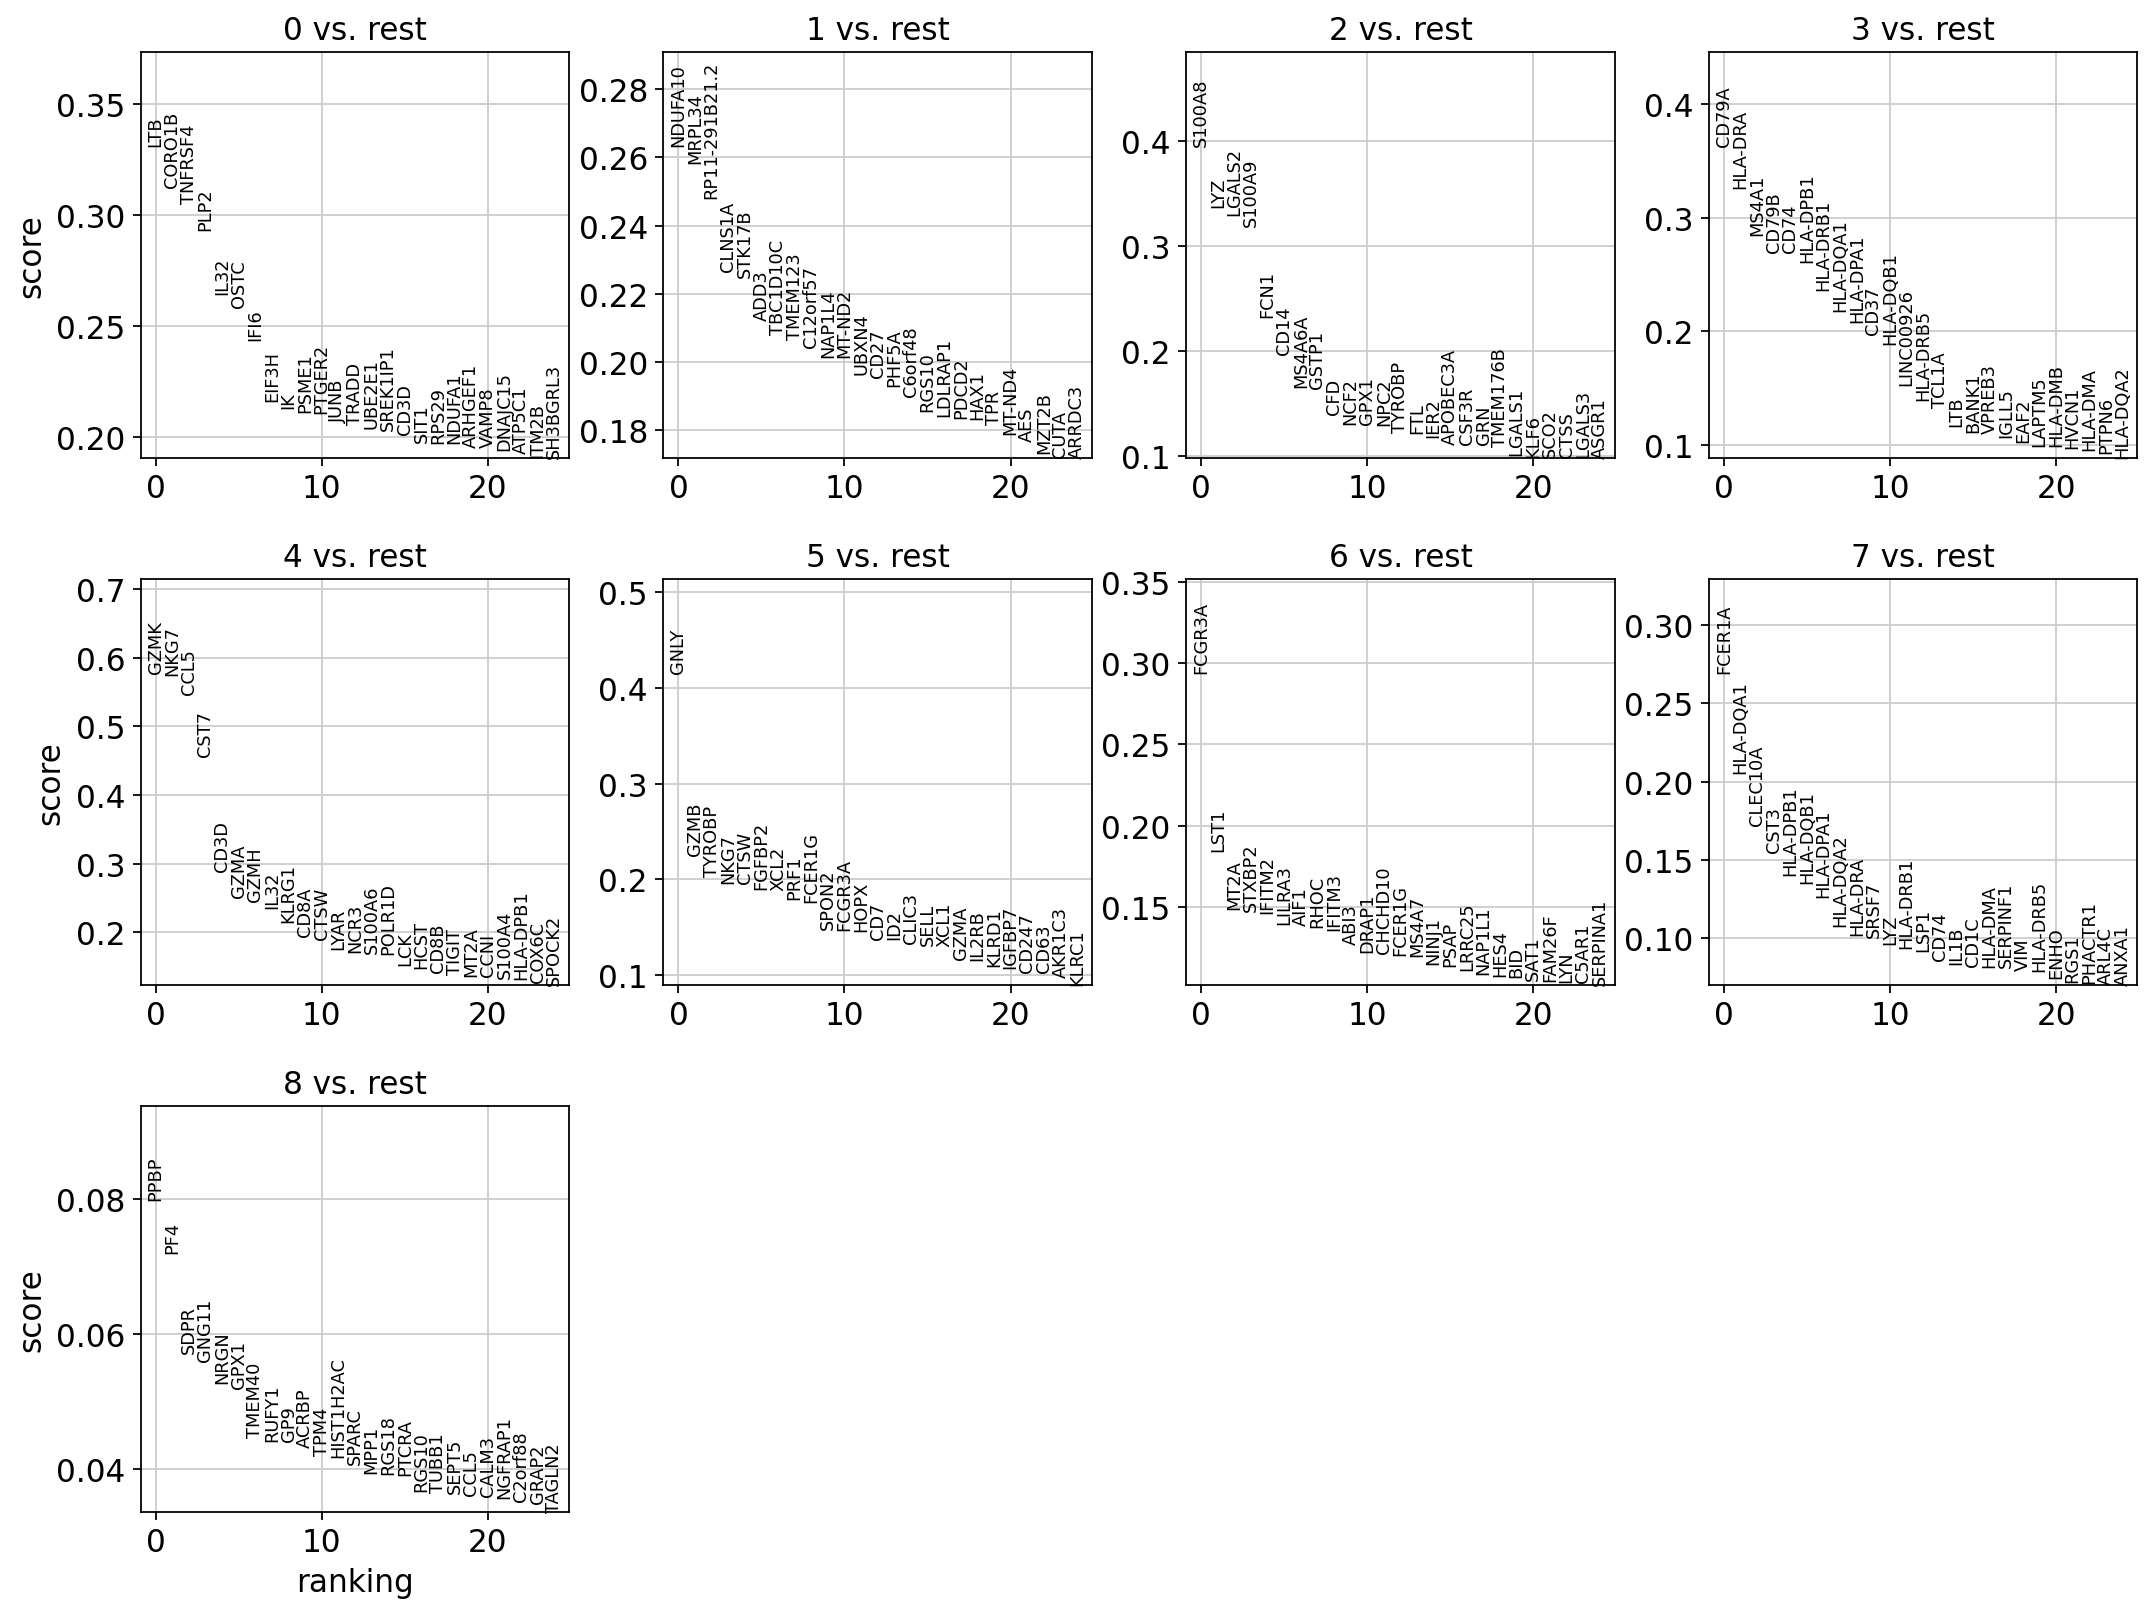

In [60]:
sc.tl.rank_genes_groups(adata, 'leiden', method='logreg', solver='liblinear')
sc.pl.rank_genes_groups(adata, n_genes=25, sharey=False)

In [61]:
marker_genes = ['IL7R', 'CD79A', 'MS4A1', 'CD8A', 'CD8B', 'LYZ', 'CD14', 'LGALS3', 'S100A8', 'GNLY', 'NKG7', 'KLRB1','FCGR3A', 'MS4A7', 'FCER1A', 'CST3', 'PPBP']

In [62]:
pd.DataFrame(adata.uns['rank_genes_groups']['names']).head(10)

,0,1,2,3,4,5,6,7,8
0,LTB,NDUFA10,S100A8,CD79A,GZMK,GNLY,FCGR3A,FCER1A,PPBP
1,CORO1B,MRPL34,LYZ,HLA-DRA,NKG7,GZMB,LST1,HLA-DQA1,PF4
2,TNFRSF4,RP11-291B21.2,LGALS2,MS4A1,CCL5,TYROBP,MT2A,CLEC10A,SDPR
3,PLP2,CLNS1A,S100A9,CD79B,CST7,NKG7,STXBP2,CST3,GNG11
4,IL32,STK17B,FCN1,CD74,CD3D,CTSW,IFITM2,HLA-DPB1,NRGN
5,OSTC,ADD3,CD14,HLA-DPB1,GZMA,FGFBP2,LILRA3,HLA-DQB1,GPX1
6,IFI6,TBC1D10C,MS4A6A,HLA-DRB1,GZMH,XCL2,AIF1,HLA-DPA1,TMEM40
7,EIF3H,TMEM123,GSTP1,HLA-DQA1,IL32,PRF1,RHOC,HLA-DQA2,RUFY1
8,IK,C12orf57,CFD,HLA-DPA1,KLRG1,FCER1G,IFITM3,HLA-DRA,GP9
9,PSME1,NAP1L4,NCF2,CD37,CD8A,SPON2,ABI3,SRSF7,ACRBP


## Ricaviamo una tabella con gruppi e punteggi

In [63]:
pd.DataFrame

pandas.core.frame.DataFrame

In [76]:
result = adata.uns['rank_genes_groups']
result

{'params': {'groupby': 'leiden',
  'reference': 'rest',
  'method': 'logreg',
  'use_raw': True,
  'layer': None,
  'corr_method': 'benjamini-hochberg'},
 'names': rec.array([('LTB', 'NDUFA10', 'S100A8', 'CD79A', 'GZMK', 'GNLY', 'FCGR3A', 'FCER1A', 'PPBP'),
            ('CORO1B', 'MRPL34', 'LYZ', 'HLA-DRA', 'NKG7', 'GZMB', 'LST1', 'HLA-DQA1', 'PF4'),
            ('TNFRSF4', 'RP11-291B21.2', 'LGALS2', 'MS4A1', 'CCL5', 'TYROBP', 'MT2A', 'CLEC10A', 'SDPR'),
            ...,
            ('HLA-DRA', 'CST7', 'HLA-DQA1', 'S100A4', 'FCER1G', 'IL32', 'LYZ', 'S100A8', 'RPS24'),
            ('CST7', 'GZMK', 'FCER1A', 'CD3D', 'TYROBP', 'VIM', 'LGALS2', 'CFD', 'RPL10'),
            ('NKG7', 'HLA-DPA1', 'FCGR3A', 'IL32', 'GNLY', 'CD3D', 'S100A8', 'FTL', 'MALAT1')],
           dtype=[('0', 'O'), ('1', 'O'), ('2', 'O'), ('3', 'O'), ('4', 'O'), ('5', 'O'), ('6', 'O'), ('7', 'O'), ('8', 'O')]),
 'scores': rec.array([( 0.3310523 ,  0.26338977,  0.3956781 ,  0.36327815,  0.57807297,  0.41554454,  0.293996

In [74]:
groups = result['names'].dtype.names

In [73]:
groups

('0', '1', '2', '3', '4', '5', '6', '7', '8')

### Il nome viene modificato da pvals a scores

In [77]:
pd.DataFrame(
        {group + '_' + key[:1]: result[key][group]
        for group in groups for key in ['names', 'scores']}).head(5)

,0_n,0_s,1_n,1_s,2_n,2_s,3_n,3_s,4_n,4_s,5_n,5_s,6_n,6_s,7_n,7_s,8_n,8_s
0,LTB,0.331052,NDUFA10,0.263390,S100A8,0.395678,CD79A,0.363278,GZMK,0.578073,GNLY,0.415545,FCGR3A,0.293996,FCER1A,0.269549,PPBP,0.079943
1,CORO1B,0.312509,MRPL34,0.258304,LYZ,0.337401,HLA-DRA,0.325968,NKG7,0.575507,GZMB,0.225877,LST1,0.184562,HLA-DQA1,0.205204,PF4,0.072077
2,TNFRSF4,0.305107,RP11-291B21.2,0.248122,LGALS2,0.329695,MS4A1,0.285207,CCL5,0.547469,TYROBP,0.203105,MT2A,0.148708,CLEC10A,0.172083,SDPR,0.057229
3,PLP2,0.293030,CLNS1A,0.226592,S100A9,0.319500,CD79B,0.270302,CST7,0.457011,NKG7,0.196637,STXBP2,0.147534,CST3,0.154630,GNG11,0.055962
4,IL32,0.264338,STK17B,0.224856,FCN1,0.232756,CD74,0.270081,CD3D,0.289161,CTSW,0.196584,IFITM2,0.146261,HLA-DPB1,0.140320,NRGN,0.052785


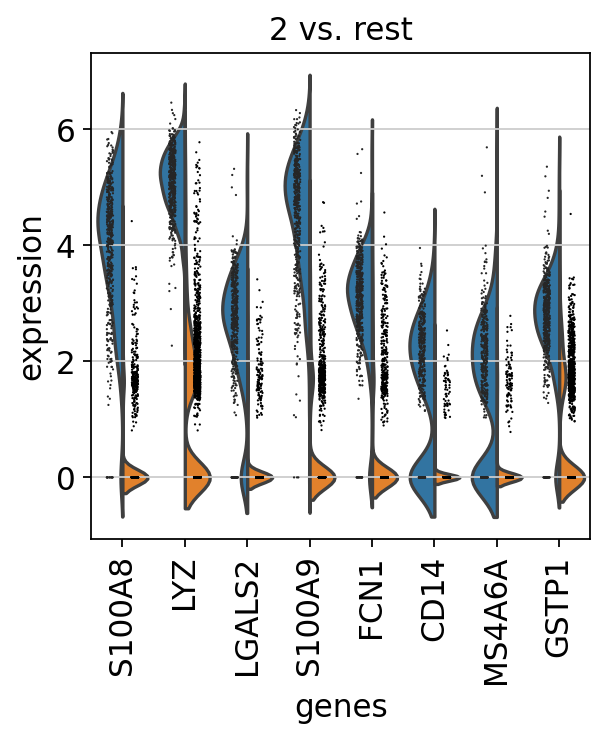

In [ ]:
sc.pl.rank_genes_groups_violin(adata, groups='2', n_genes=8)

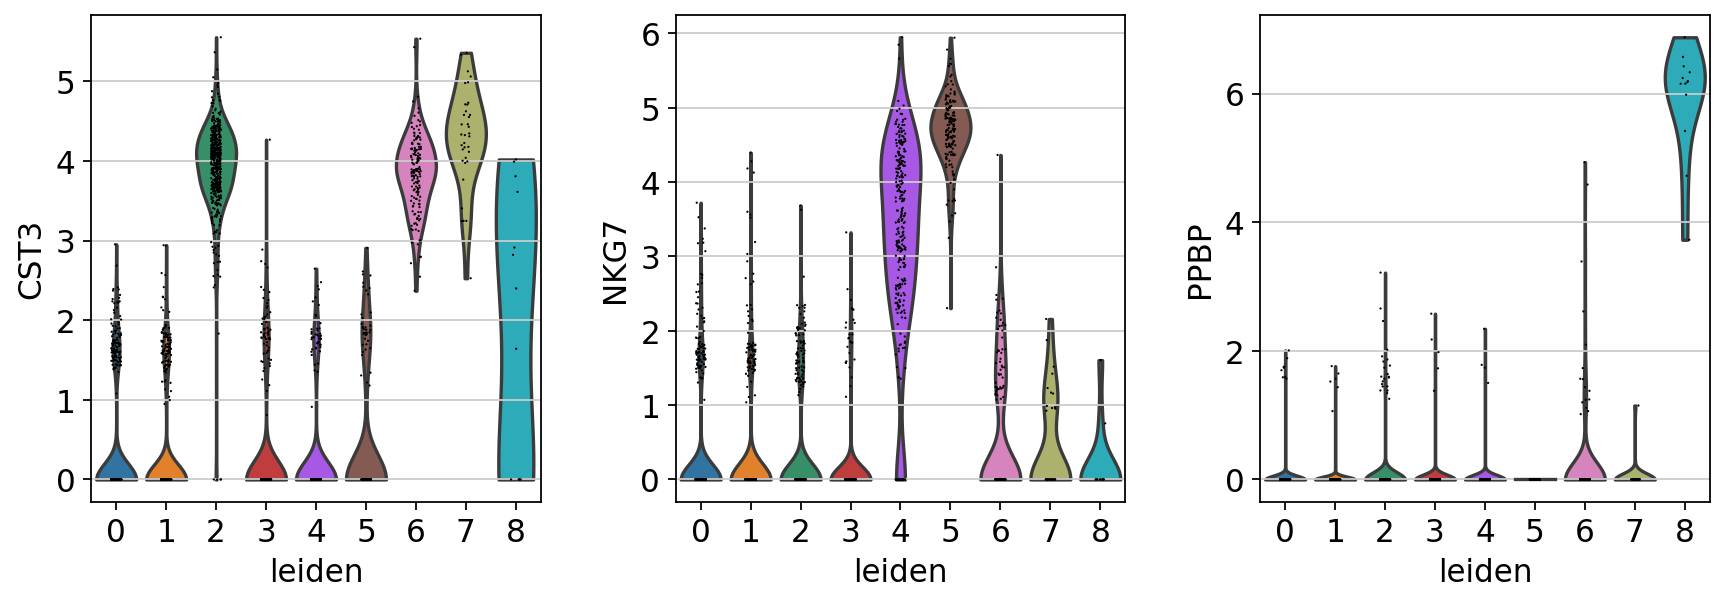

In [ ]:
sc.pl.violin(adata, ['CST3', 'NKG7', 'PPBP'], groupby='leiden')

In [ ]:
new_cluster_names = [
    'CD4 T', 'CD14 Monocytes', 'B', 'CD8 T','NK', 'FCGR3A Monocytes','Dendritic', 'Megakaryocytes']
adata.rename_categories('leiden', new_cluster_names)

ValueError: new categories need to have the same number of items as the old categories!